# Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as st
from scipy.stats import t, shapiro
import random
from scipy.stats import ks_2samp
!pip install pmdarima
from pmdarima import auto_arima
from scipy.stats import shapiro

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
plt.style.use('fivethirtyeight')

# IMPORTATION DONNEES

## Consomation

In [4]:
# importation des données consommation
data = pd.read_csv("/content/drive/My Drive/DATASETS/eCO2mix_RTE_energie_M.xls.csv")
data.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,909,19,86,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,283,123,120,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,118,50,104,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,208,14,31,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,249,8,36,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Mois                                      1182 non-null   object 
 1   Qualité                                   1182 non-null   object 
 2   Territoire                                1182 non-null   object 
 3   Production totale                         1182 non-null   int64  
 4   Production nucléaire                      732 non-null    float64
 5   Production thermique totale               1182 non-null   int64  
 6   Production thermique charbon              793 non-null    float64
 7   Production thermique fioul                1182 non-null   int64  
 8   Production thermique gaz                  1182 non-null   int64  
 9   Production hydraulique                    1182 non-null   int64  
 10  Production éolien                   

In [6]:
data.shape

(1182, 22)

In [7]:
# suppression données inutiles
data = data.loc[data["Mois"] != "0000-00",]
data = data.loc[data["Territoire"] == "France",]

In [8]:
data.shape

(101, 22)

In [9]:
data.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
13,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
14,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
15,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
16,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
17,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,454,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [10]:
# suppression données initules
data = data[["Mois","Consommation totale"]]


In [11]:
# Exploration plage date
data.iloc[-1,]

Mois                   2020-05
Consommation totale      30390
Name: 1175, dtype: object

* Données consomation de janvier 2012 à mai 2020

In [12]:
# sauvegarde
data_conso_full = data

## DJU

In [13]:
# importation données dju
dju = pd.read_csv("/content/drive/My Drive/DATASETS/calcul_DJU_06_07_2020.csv",decimal=",")
dju.head(10)

,YEAR,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC
0,2019,428.6,296.4,266.0,203.4,150.4,21.6,0.0,0.0,0.0,0.0,0.0,0.0
1,2018,322.3,456.9,332.4,154.8,97.2,30.0,4.3,25.3,76.6,149.4,298.6,349.7
2,2017,498.8,301.0,236.4,231.8,102.7,30.7,21.0,31.5,94.6,136.4,311.1,394.2
3,2016,389.3,347.5,346.3,249.4,129.4,52.8,28.4,25.8,44.5,205.4,310.6,426.0
4,2015,422.7,392.8,307.6,190.9,132.2,51.3,25.7,24.2,106.9,208.0,218.0,269.3
5,2014,344.5,295.6,271.9,171.0,134.5,51.7,26.6,53.5,54.8,121.5,242.7,397.6
6,2013,453.5,427.5,400.5,243.9,185.3,69.1,14.7,40.5,74.4,128.9,323.9,381.8
7,2012,365.4,466.9,247.1,257.4,109.4,64.0,44.2,25.7,101.9,169.9,317.8,370.3


In [14]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    8 non-null      int64  
 1   JAN     8 non-null      float64
 2   FÉV     8 non-null      float64
 3   MAR     8 non-null      float64
 4   AVR     8 non-null      float64
 5   MAI     8 non-null      float64
 6   JUN     8 non-null      float64
 7   JUI     8 non-null      float64
 8   AOÛ     8 non-null      float64
 9   SEP     8 non-null      float64
 10  OCT     8 non-null      float64
 11  NOV     8 non-null      float64
 12  DÉC     8 non-null      float64
dtypes: float64(12), int64(1)
memory usage: 960.0 bytes


In [15]:
# renommage colonnes
dju.columns = ['annee', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# Changement format large vers long
dju = pd.melt(dju, id_vars='annee', var_name='mois', value_name='dju')

# Création date en format correct, et on convertion en datetime
dju['date'] = dju['annee'].astype(str) + '-' + dju['mois']


In [16]:
dju.head(5)

,annee,mois,dju,date
0,2019,01,428.6,2019-01
1,2018,01,322.3,2018-01
2,2017,01,498.8,2017-01
3,2016,01,389.3,2016-01
4,2015,01,422.7,2015-01


In [17]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   annee   96 non-null     int64  
 1   mois    96 non-null     object 
 2   dju     96 non-null     float64
 3   date    96 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ KB


In [18]:
# Suppression mois avec données nulles
dju = dju.loc[dju['dju'] != 0]
dju = dju[["dju","date"]]
dju.head(5)

,dju,date
0,428.6,2019-01
1,322.3,2018-01
2,498.8,2017-01
3,389.3,2016-01
4,422.7,2015-01


In [19]:
# merge données consommation et dju
data = pd.merge(data, dju, left_on="Mois", right_on="date")

In [20]:
# conservation données utiles
data = data[["date","Consommation totale","dju"]]

data.head(5)

,date,Consommation totale,dju
0,2012-01,51086,365.4
1,2012-02,54476,466.9
2,2012-03,43156,247.1
3,2012-04,40176,257.4
4,2012-05,35257,109.4


In [21]:
# Changement type série temporelle
data.date = pd.to_datetime(data.date)
# Passage date en index
data.set_index("date", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2012-01-01 to 2019-06-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consommation totale  90 non-null     int64  
 1   dju                  90 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 2.1 KB


In [22]:
data.head(5)

,Consommation totale,dju
date,,
2012-01-01,51086,365.4
2012-02-01,54476,466.9
2012-03-01,43156,247.1
2012-04-01,40176,257.4
2012-05-01,35257,109.4


# DESCRIPTIF

In [23]:
data.shape

(90, 2)

* 90 mois

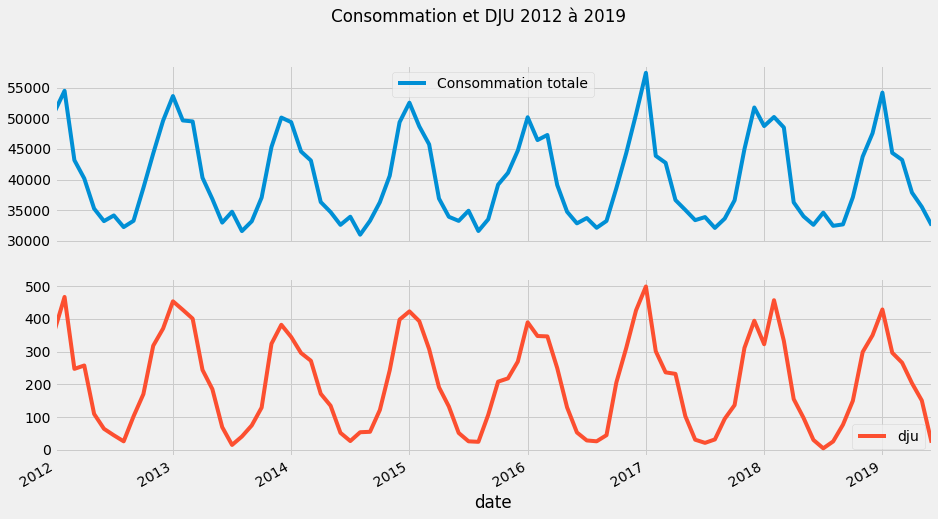

In [24]:
# graphique données complètes
data.plot(figsize = (14,8), subplots=True)
plt.suptitle("Consommation et DJU 2012 à 2019")
plt.show()

* Additif

In [25]:
# tendances centrales
data.describe()

,Consommation totale,dju
count,90.000000,90.000000
mean,40187.800000,204.544444
std,7138.137168,142.359230
min,31004.000000,4.300000
25%,33757.750000,65.275000
50%,37488.500000,197.150000
75%,45631.750000,321.175000
max,57406.000000,498.800000


In [26]:
# CV Consommation
np.std(data["Consommation totale"]) / np.mean(data["Consommation totale"]) 

0.1766299742135906

In [27]:
# CV dju
np.std(data["dju"]) / np.mean(data["dju"]) 

0.6921045280246256

## Corrélation

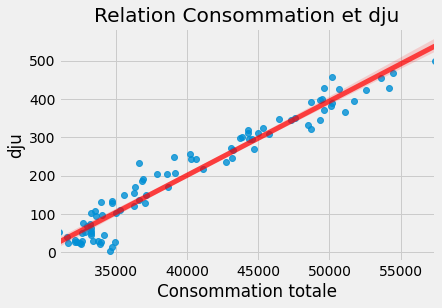

In [28]:
# graphique conso et dju pour recherche corrélation
sns.regplot(x=data["Consommation totale"], y=data["dju"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title("Relation Consommation et dju")
plt.show()


In [29]:
# calcul corrélation
data.corr()

,Consommation totale,dju
Consommation totale,1.000000,0.970461
dju,0.970461,1.000000


# Correction effet température


In [30]:
# définition features et target
Y = data["Consommation totale"]
X = data["dju"]

# ajout constante
X = sm.add_constant(X) #  constant

# Entrainement modele
model = sm.OLS(Y, X).fit()

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation totale   R-squared:                       0.942
Model:                             OLS   Adj. R-squared:                  0.941
Method:                  Least Squares   F-statistic:                     1424.
Date:                 Fri, 17 Jul 2020   Prob (F-statistic):           3.98e-56
Time:                         13:42:46   Log-Likelihood:                -797.82
No. Observations:                   90   AIC:                             1600.
Df Residuals:                       88   BIC:                             1605.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.023e+04    320.783     94.25

### Atypicité des observations

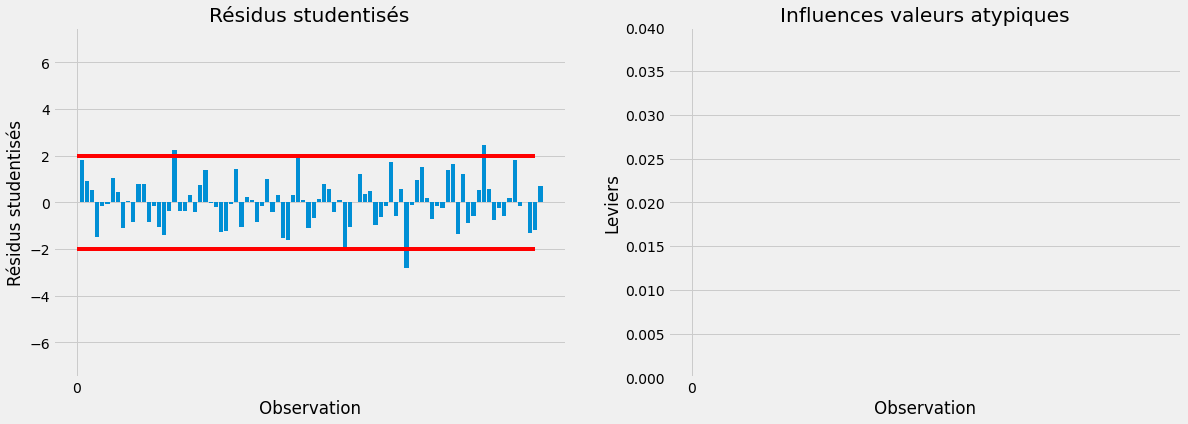

In [31]:
# Sélection du seuil
alpha = 0.05

# nb observation
n = data.shape[0]

# nb variables
p = 1

#création df analyse
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

# Calcul levier, résidus studentisés et Cook
analyses['levier'] = model.get_influence().hat_matrix_diag
analyses['rstudent'] = model.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
influence = model.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']

# Calcul des seuils
seuil_levier = 2*p/n
seuil_dcook = 4/(n-p)
#Sélection observations atypiques
atypiques = analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent), :]

# graphiques Résidus et distance cooks
fig = plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n-1, step=500))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n-1], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n-1], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.ylim(-7.5, 7.5)
plt.title('Résidus studentisés')
plt.subplot(122)
plt.bar(atypiques['obs'], atypiques['dcooks'])
plt.xticks(np.arange(0, n-1, step=500))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n-1], [seuil_dcook, seuil_dcook], color='r')
plt.ylim(0, 0.04)
plt.title('Influences valeurs atypiques')
plt.show()

* Aucune valeurs atypiques et influentes


### Variances résidus


Text(0.5, 1.0, 'Variance des résidus')

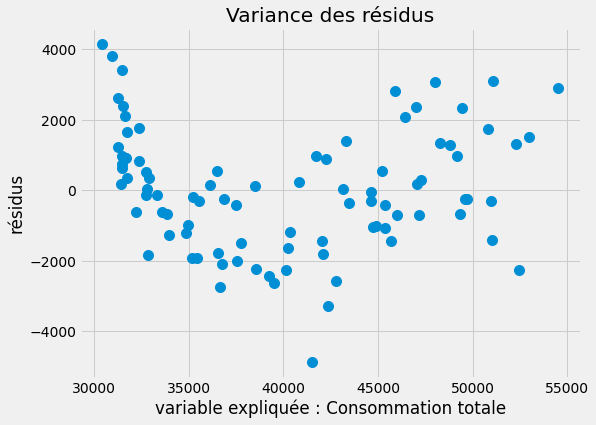

In [32]:
# graphique résidus
fig = plt.figure(figsize=(8,6))
plt.plot(model.fittedvalues, model.resid, '.',markersize=20)
plt.xlabel('variable expliquée : Consommation totale')
_ = plt.ylabel('résidus')
plt.title('Variance des résidus')

### Normalité des résidus

#### Distribution des résidus

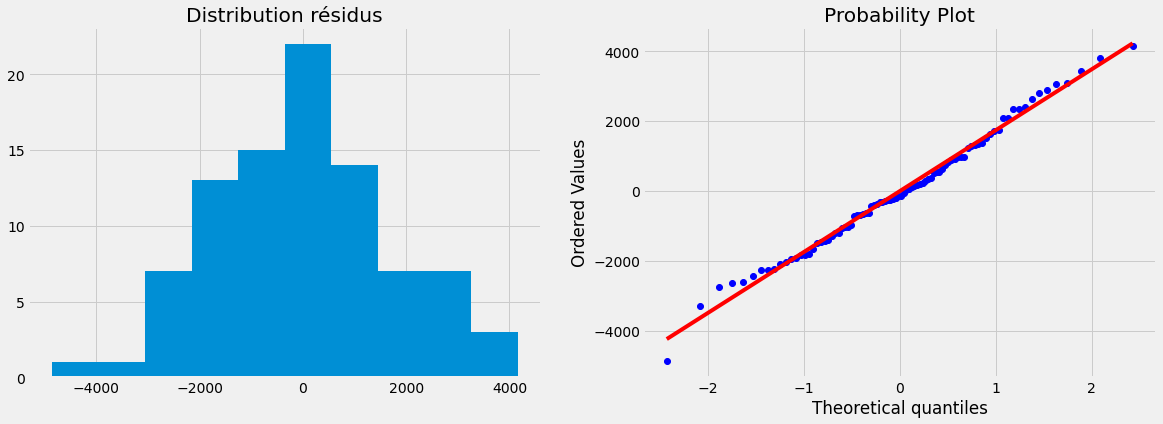

In [33]:
# graphiques normalité résidus
fig = plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(model.resid)
plt.title('Distribution résidus')
plt.subplot(122)
st.probplot(model.resid, plot=plt)
plt.show()

#### Adhésion loi normale des résidus
H0 : distribution selon loi normale

In [34]:
#Kolmogorov-Smirnov
print("mod.resid")
print(ks_2samp(model.resid,list(np.random.normal(np.mean(model.resid), np.std(model.resid), 1000))))


mod.resid
Ks_2sampResult(statistic=0.08188888888888889, pvalue=0.6060707093220997)


* Adhésion loi normale des résidus

## Correction

In [35]:
print(model.params['dju'])

48.660600038053886


In [36]:
# correction conso de l'effet température
data['consommation_corrigee'] = data["Consommation totale"] - data['dju'] * model.params['dju']
data.head(5)

,Consommation totale,dju,consommation_corrigee
date,,,
2012-01-01,51086,365.4,33305.416746
2012-02-01,54476,466.9,31756.365842
2012-03-01,43156,247.1,31131.965731
2012-04-01,40176,257.4,27650.761550
2012-05-01,35257,109.4,29933.530356


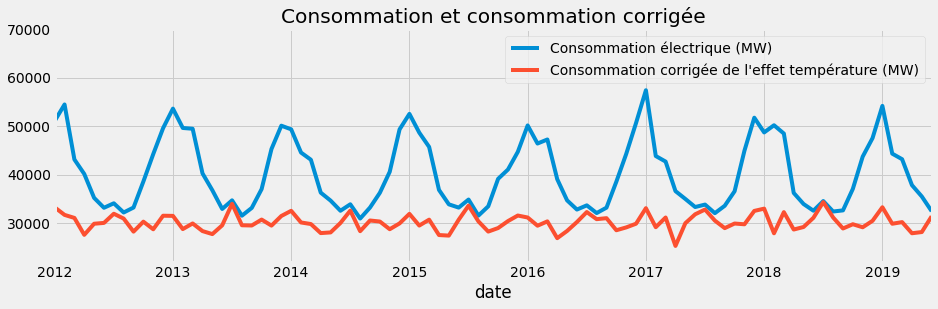

In [37]:
# graphique conso et conso corrigée température
data.plot(y = ['Consommation totale', 'consommation_corrigee'], 
          label=["Consommation électrique (MW)", "Consommation corrigée de l'effet température (MW)"],
          figsize=(14,4))
plt.title("Consommation et consommation corrigée")
plt.ylim((22000,70000))
plt.show()

# Désaisonnalité

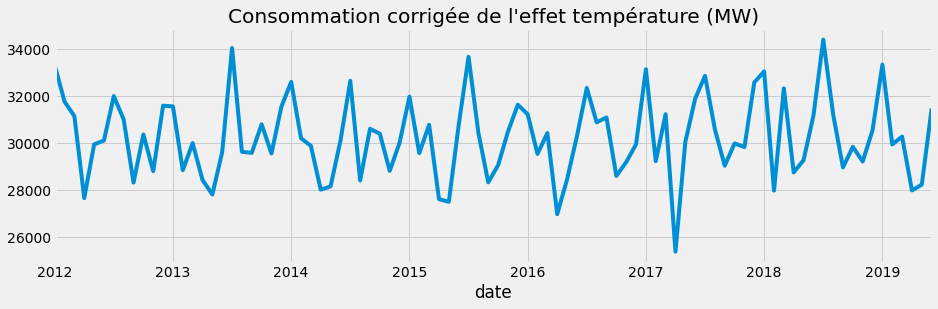

In [38]:
# graphyque donnée conso corrigée
data['consommation_corrigee'].plot(figsize=(14,4))
plt.title("Consommation corrigée de l'effet température (MW)")
plt.show()

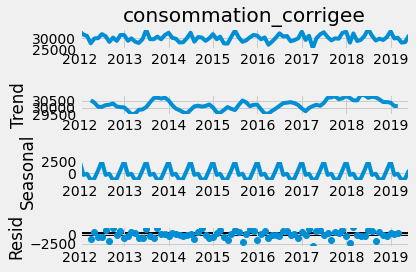

In [39]:
# décomposition sur 6 mois
decomp_x = sm.tsa.seasonal_decompose(data['consommation_corrigee'],  model='additive', period=6)
decomp_x.plot()
plt.show()

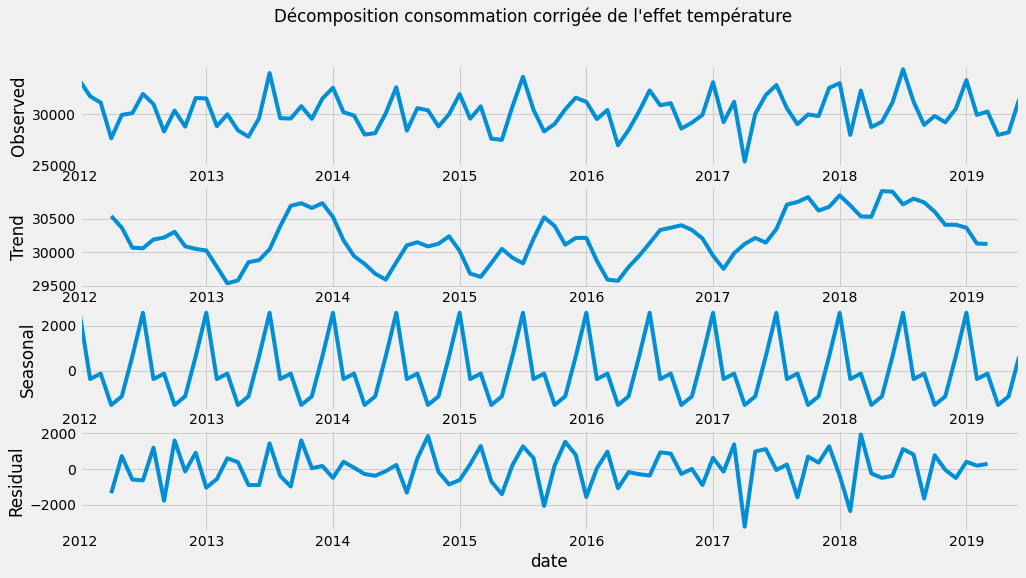

In [40]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
data['consommation_corrigee'].plot(ax=ax1)
decomp_x.trend.plot(ax=ax2)
decomp_x.seasonal.plot(ax=ax3)
decomp_x.resid.plot(ax=ax4)

ax1.set_ylabel("Observed")
ax2.set_ylabel("Trend")
ax3.set_ylabel("Seasonal")
ax4.set_ylabel("Residual")
plt.suptitle("Décomposition consommation corrigée de l'effet température")
plt.show()

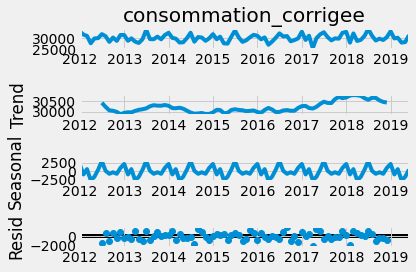

In [41]:
# décomposition sur 12 mois
decomp_x = sm.tsa.seasonal_decompose(data['consommation_corrigee'],  model='additive', period=12)
decomp_x.plot()
plt.show()

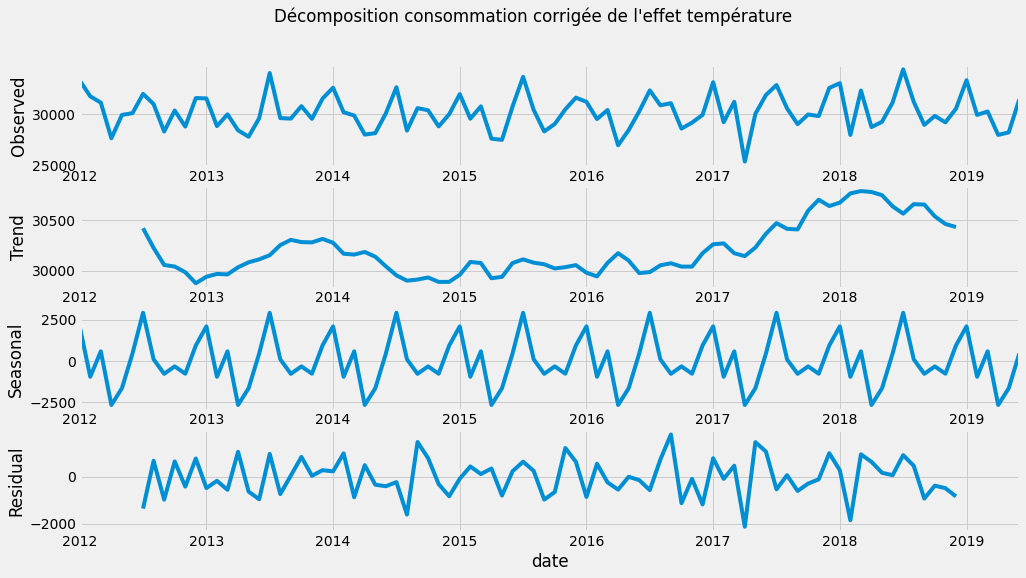

In [42]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
data['consommation_corrigee'].plot(ax=ax1)
decomp_x.trend.plot(ax=ax2)
decomp_x.seasonal.plot(ax=ax3)
decomp_x.resid.plot(ax=ax4)

ax1.set_ylabel("Observed")
ax2.set_ylabel("Trend")
ax3.set_ylabel("Seasonal")
ax4.set_ylabel("Residual")
plt.suptitle("Décomposition consommation corrigée de l'effet température")
plt.show()

* Tendance ascendante
* Saisonalité
* stationaire ?

### Ad fuller test
HO = non stationnarité

In [43]:
results = adfuller(data['consommation_corrigee'])

In [44]:
print(results[1])

0.3448197297911032


* P > 05 -> non stationnarisé


### Saisonnalité


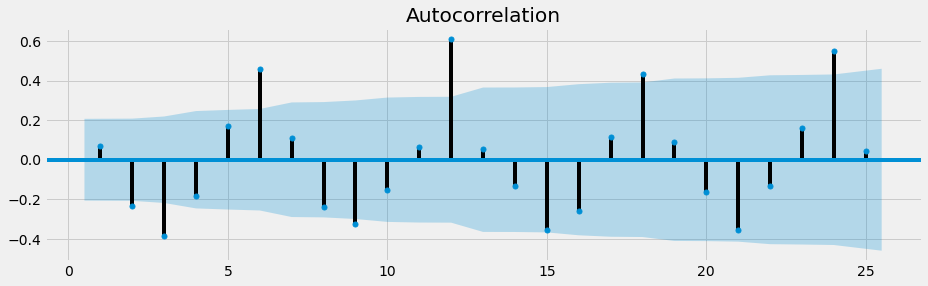

In [45]:
# ACF données corrigées
fig, ax = plt.subplots(1,1,figsize=(14,4))
plot_acf(data['consommation_corrigee'], ax = ax, lags=25, zero=False)
plt.show()

* Saisonnalité de 6 mois


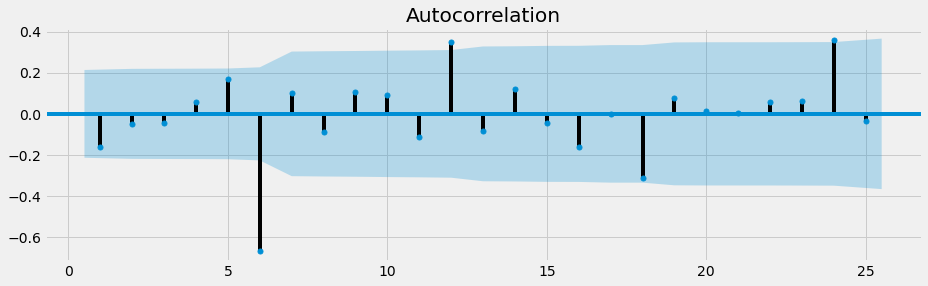

In [46]:
data_stationary = data['consommation_corrigee'].diff(6).dropna()

fig, ax = plt.subplots(1,1,figsize=(14,4))
plot_acf(data_stationary, ax = ax, lags=25, zero=False)
plt.show()

### Ad fuller test
HO = non stationnarité

In [47]:
results = adfuller(data_stationary)

In [48]:
print(results[1])

0.014488968170391173


* p < 0.5, rejet de H0 = Stationnaire

# Correction saisonnalité


In [49]:
# correction sur période 6 mois
decomp_x = sm.tsa.seasonal_decompose(data['consommation_corrigee'],  model='additive', period=6)

data["consommation_stationnaire"] = data['consommation_corrigee'] - decomp_x.seasonal
data.head(5)

,Consommation totale,dju,consommation_corrigee,consommation_stationnaire
date,,,,
2012-01-01,51086,365.4,33305.416746,30737.497657
2012-02-01,54476,466.9,31756.365842,32136.044377
2012-03-01,43156,247.1,31131.965731,31269.368462
2012-04-01,40176,257.4,27650.761550,29182.799205
2012-05-01,35257,109.4,29933.530356,31083.024131


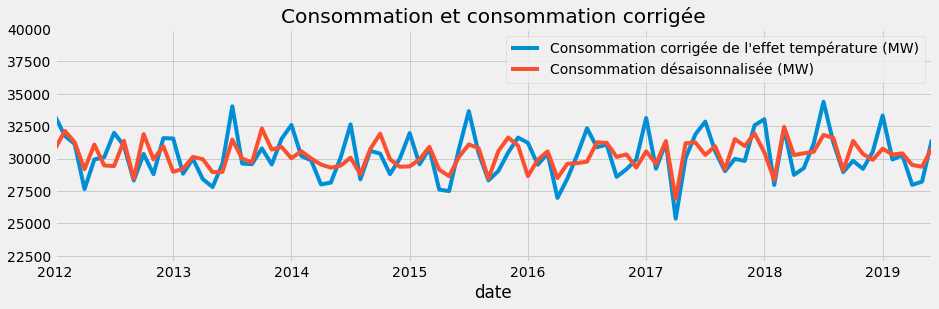

In [50]:
# graphique conso corrigée et désaisonnalisée
data.plot(y = ['consommation_corrigee','consommation_stationnaire'], 
          label=["Consommation corrigée de l'effet température (MW)",
                 "Consommation désaisonnalisée (MW)"],
          figsize=(14,4))
plt.title("Consommation et consommation corrigée")
plt.ylim((22000,40000))
plt.legend()
plt.show()

# Modélisation

## Train, Test split

In [51]:
data.shape


(90, 4)

* Train = 60 obs 
* Test = 30 obs


In [52]:
# séparation jeu entrainement
data_train = data.loc[:"2016-12-01",]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2012-01-01 to 2016-12-01
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Consommation totale        60 non-null     int64  
 1   dju                        60 non-null     float64
 2   consommation_corrigee      60 non-null     float64
 3   consommation_stationnaire  60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.3 KB


In [53]:
# séparation jeu test 
data_test = data.loc["2017-01-01":,]
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2017-01-01 to 2019-06-01
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Consommation totale        30 non-null     int64  
 1   dju                        30 non-null     float64
 2   consommation_corrigee      30 non-null     float64
 3   consommation_stationnaire  30 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.2 KB


Text(0.5, 1.0, "Consommation corrigée de l'effet température (MW)")

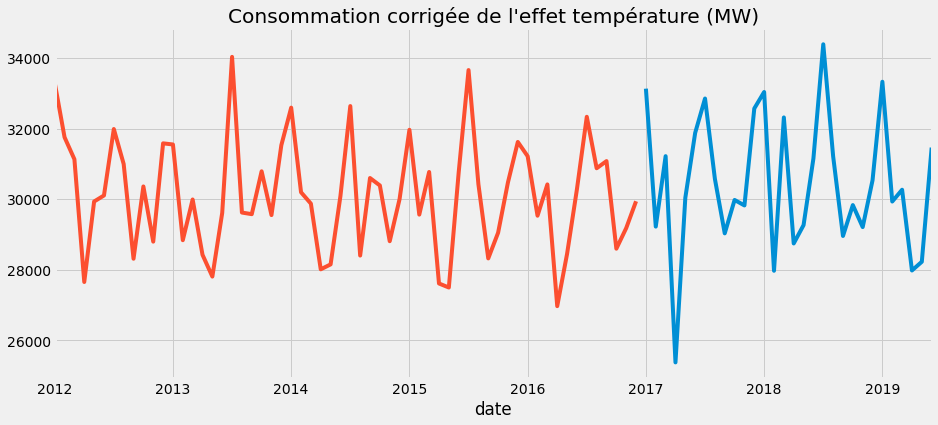

In [54]:
# graph train et test 
fig, ax = plt.subplots(1,1, figsize=(14,6))
data_test["consommation_corrigee"].plot(ax=ax)
data_train["consommation_corrigee"].plot(ax=ax)
plt.title("Consommation corrigée de l'effet température (MW)")

## Vérification saisonnalité

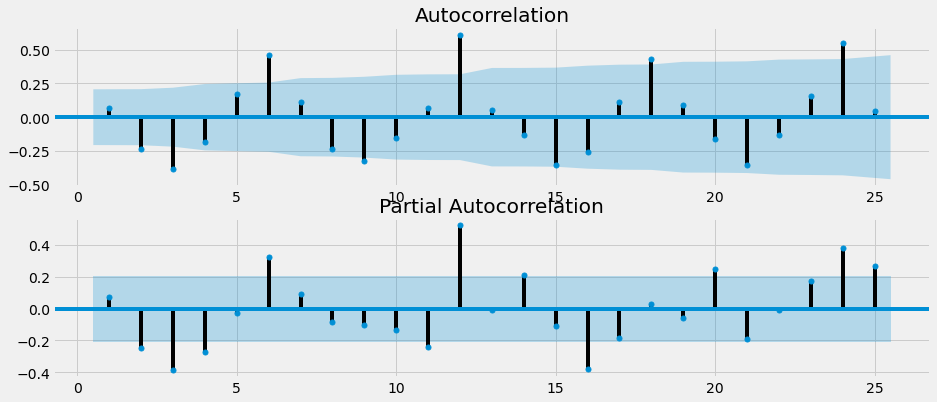

In [55]:
# figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,6))

# ACF plot
plot_acf(data["consommation_corrigee"], lags=25, zero=False, ax=ax1)

# PACF plot
plot_pacf(data["consommation_corrigee"], lags=25, zero=False, ax=ax2)

plt.show()

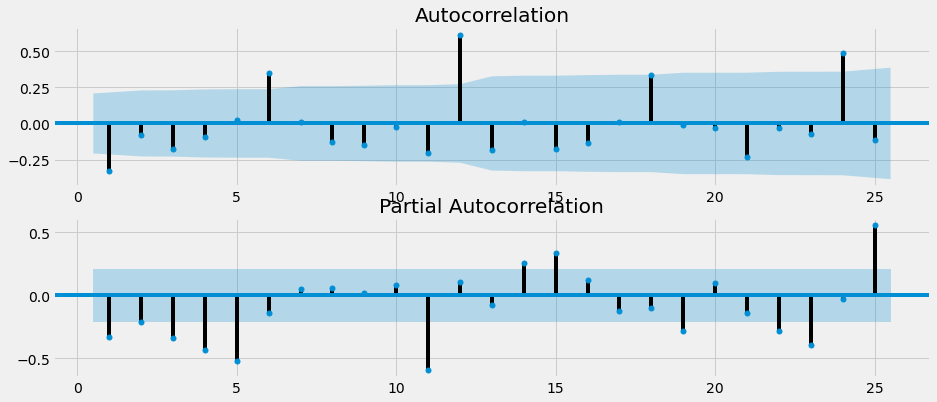

In [56]:
# figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,6))

# ACF plot
plot_acf(data["consommation_corrigee"].diff().dropna(), lags=25, zero=False, ax=ax1)

# PACF plot
plot_pacf(data["consommation_corrigee"].diff().dropna(), lags=25, zero=False, ax=ax2)

plt.show()

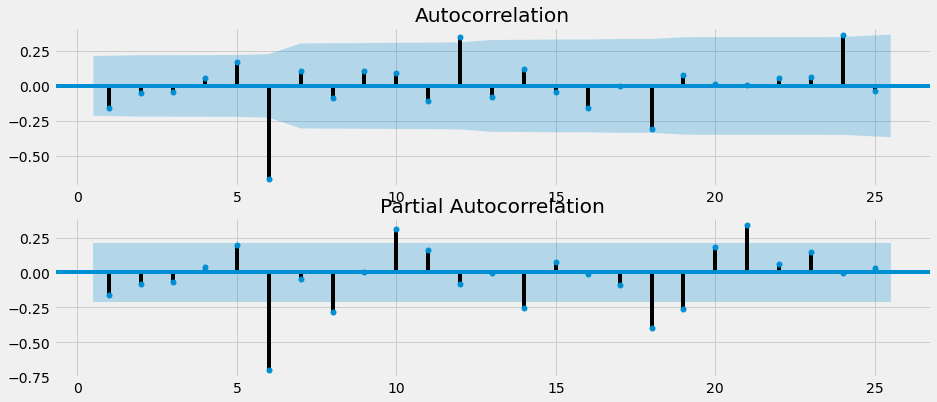

In [57]:
# figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,6))

# ACF plot
plot_acf(data["consommation_corrigee"].diff(6).dropna(), lags=25, zero=False, ax=ax1)

# PACF plot
plot_pacf(data["consommation_corrigee"].diff(6).dropna(), lags=25, zero=False, ax=ax2)

plt.show()

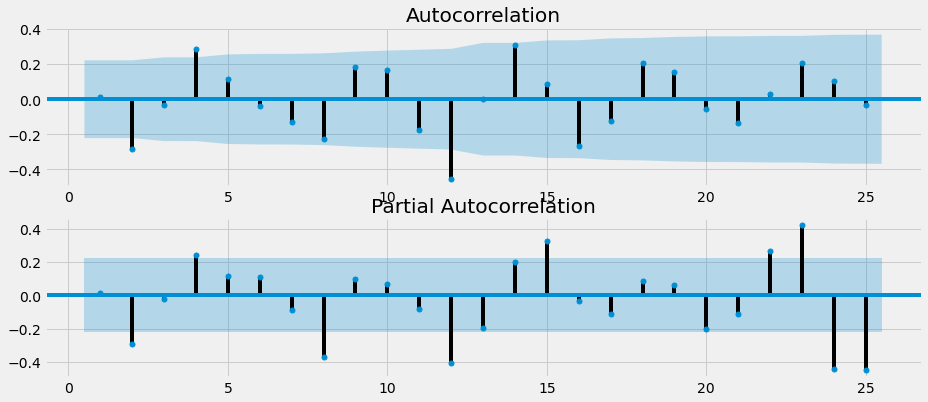

In [58]:
# figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,6))

# ACF plot
plot_acf(data["consommation_corrigee"].diff(12).dropna(), lags=25, zero=False, ax=ax1)

# PACF plot
plot_pacf(data["consommation_corrigee"].diff(12).dropna(), lags=25, zero=False, ax=ax2)

plt.show()

In [59]:
# test stationnarité 12 mois
results = adfuller(data["consommation_corrigee"].diff(12).dropna())
print(results)
print(results[1])

(-3.5818491114571835, 0.00611766688214778, 12, 65, {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}, 1096.2960929587541)
0.00611766688214778


In [60]:
# test stationnarité 6 mois
results = adfuller(data["consommation_corrigee"].diff(6).dropna())
print(results)
print(results[1])

(-3.308816017150329, 0.014488968170391173, 9, 74, {'1%': -3.5219803175527606, '5%': -2.9014701097664504, '10%': -2.58807215485756}, 1205.4840318611336)
0.014488968170391173


* Stationnaire 6 mois


In [61]:
from pmdarima.arima.utils import nsdiffs

nsdiffs(data["consommation_corrigee"],
        m=12,
        max_D=12,
        test='ocsb')  # -> 0

0

In [62]:
# estimate number of seasonal differences using a Canova-Hansen test
D = nsdiffs(data["consommation_corrigee"],
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
D

0

## Holt Winters


### HW 6 mois

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


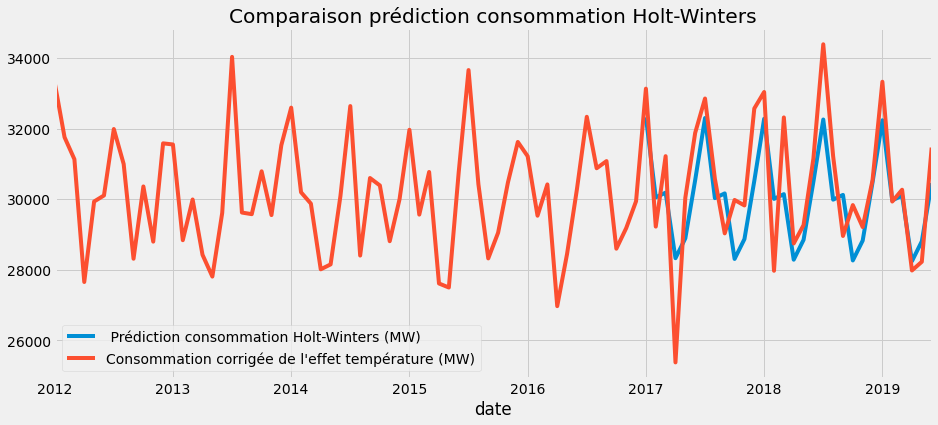

In [63]:
# préparation modele
hw = ExponentialSmoothing(data_train["consommation_corrigee"], seasonal_periods=6, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(30)

# graph pred et actual 
fig, ax = plt.subplots(1,1, figsize=(14,6))
hw_pred.plot(ax = ax, label=" Prédiction consommation Holt-Winters (MW)")
data["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation Holt-Winters")
plt.show()

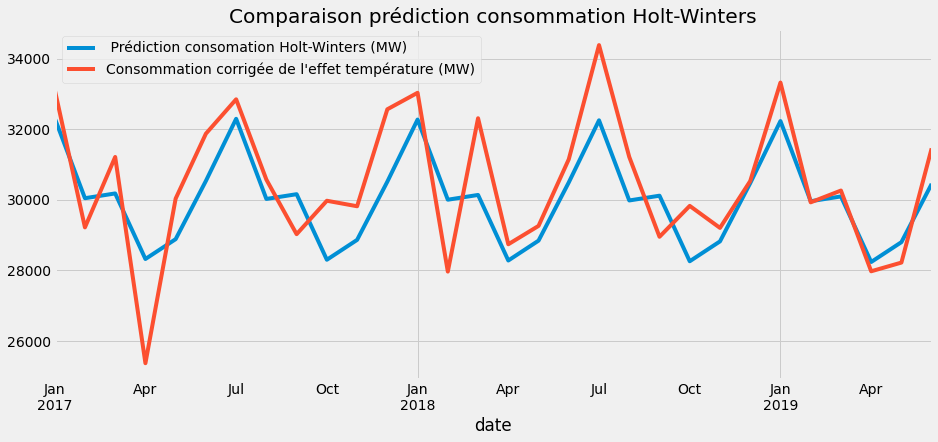

In [64]:
# graphique comparation pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
hw_pred.plot(ax = ax, label=" Prédiction consomation Holt-Winters (MW)")
data_test["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation Holt-Winters")
plt.show()

#### Evaluation prédictions


In [65]:
# création df pred et actual
df = pd.DataFrame({'Actual': data_test["consommation_corrigee"], 'Predicted': hw_pred })
df = df.dropna()

#### Comparaison actual - predicted

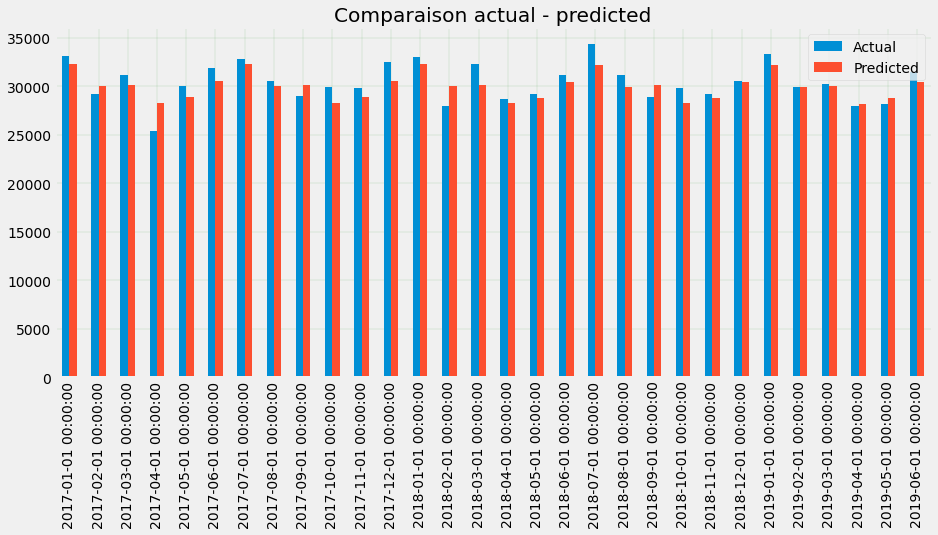

In [66]:
# comparaison graphique pred et actual
df1 = df
df1.plot(kind='bar',figsize=(14,6))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
plt.title("Comparaison actual - predicted")
plt.show()

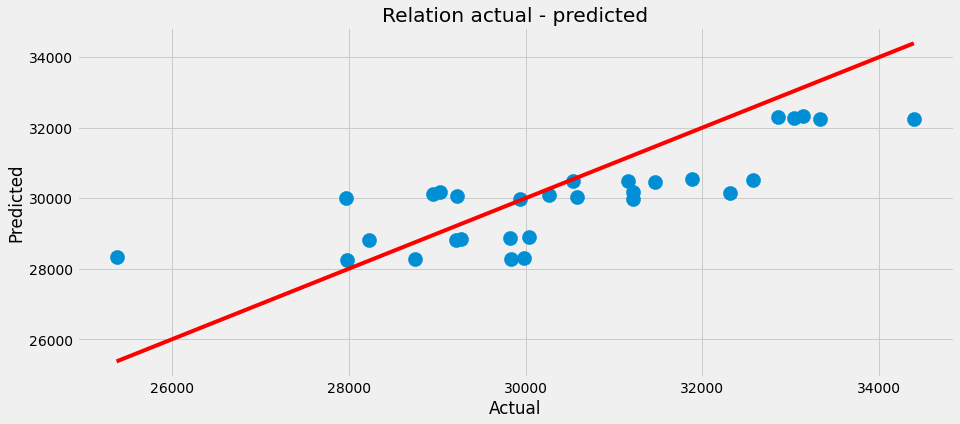

In [67]:
# comparaison graphique
df1.plot(kind='scatter',x = "Actual", y = "Predicted",figsize=(14,6), s=200)
ident = [min(df1.Actual),max(df1.Actual)]
plt.plot(ident,ident, color = "r")
plt.title("Relation actual - predicted")
plt.show()

#### rmse et mape


In [68]:
rmse = np.sqrt(((df.Actual-df.Predicted)**2).mean())
rmse

1252.4220553725618

In [69]:
mape=(np.abs(1-df.Predicted/df.Actual)).mean()*100
round(mape,2)

3.44

### HW 12 mois


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


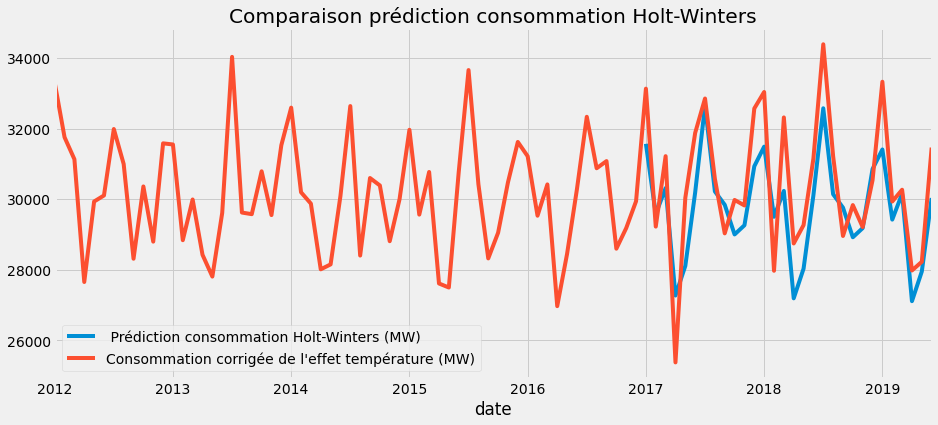

In [70]:
hw = ExponentialSmoothing(data_train["consommation_corrigee"], seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(30)

# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
hw_pred.plot(ax = ax, label=" Prédiction consommation Holt-Winters (MW)")
data["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation Holt-Winters")
plt.show()

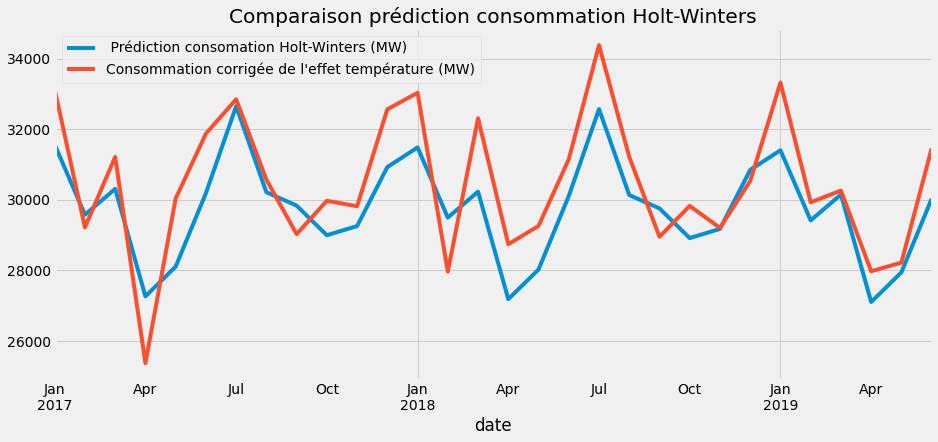

In [71]:
# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
hw_pred.plot(ax = ax, label=" Prédiction consomation Holt-Winters (MW)")
data_test["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation Holt-Winters")
plt.show()

#### Evaluation prédictions


In [72]:
df = pd.DataFrame({'Actual': data_test["consommation_corrigee"], 'Predicted': hw_pred })
df = df.dropna()

#### Comparaison actual - predicted

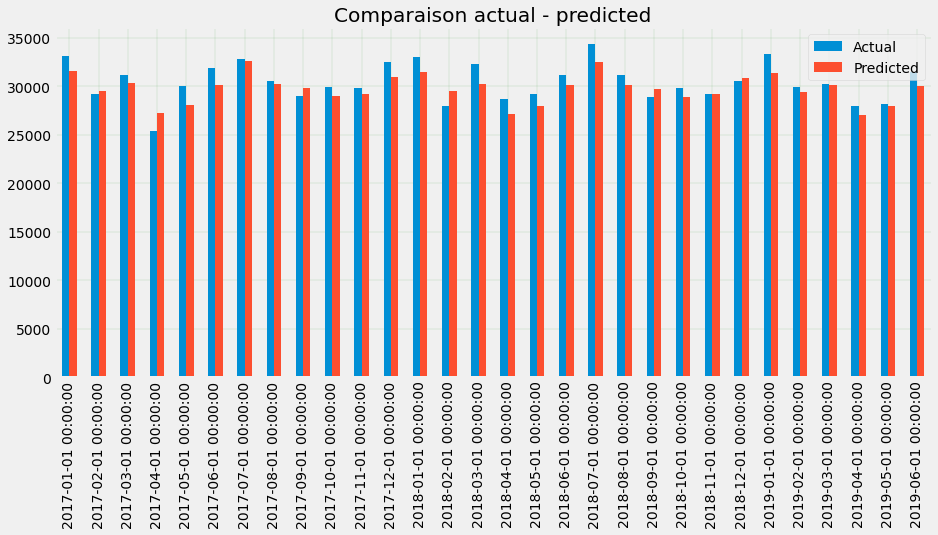

In [73]:
# comparaison graphique pred et actual
df1 = df
df1.plot(kind='bar',figsize=(14,6))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
plt.title("Comparaison actual - predicted")
plt.show()

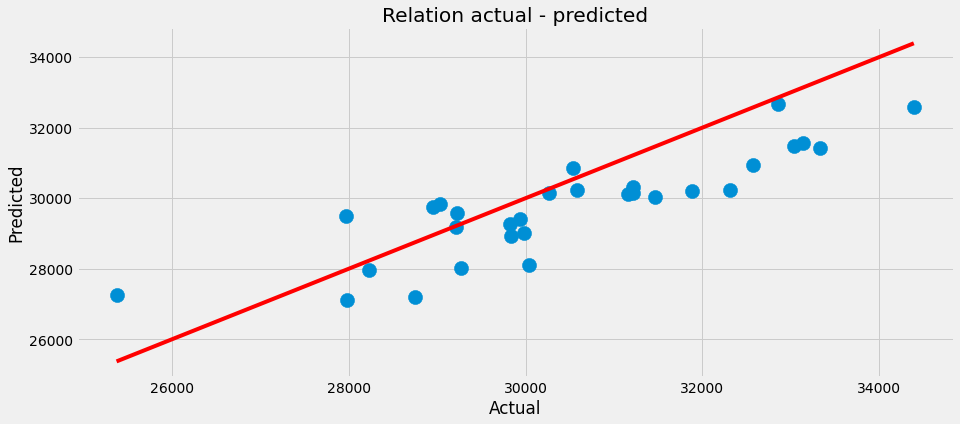

In [74]:
# comparaison graphique pred et actual
df1.plot(kind='scatter',x = "Actual", y = "Predicted",figsize=(14,6), s=200)
ident = [min(df1.Actual),max(df1.Actual)]
plt.plot(ident,ident, color = "r")
plt.title("Relation actual - predicted")
plt.show()

#### rmse et mape


In [75]:
rmse = np.sqrt(((df.Actual-df.Predicted)**2).mean())
rmse

1229.5958912037493

In [76]:
mape=(np.abs(1-df.Predicted/df.Actual)).mean()*100
round(mape,2)

3.49

## SARIMA


### Recherche sur grille paramètres model SARIMA 6 mois

* Recherche avec saisonnalité de 6 sur 1 différences

In [77]:
# recherche sur grille
stepwise_model = auto_arima(data["consommation_corrigee"], m=6,
                           D=1,seasonal=True,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='aic')
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,6) [intercept=True]; AIC=1482.872, BIC=1502.318, Time=1.449 seconds
Fit ARIMA(0,0,0)x(0,1,0,6) [intercept=True]; AIC=1492.949, BIC=1497.811, Time=0.014 seconds
Fit ARIMA(1,0,0)x(1,1,0,6) [intercept=True]; AIC=1491.716, BIC=1501.439, Time=0.118 seconds
Fit ARIMA(0,0,1)x(0,1,1,6) [intercept=True]; AIC=1611.678, BIC=1621.402, Time=0.520 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,1,0,6) [intercept=False]; AIC=1490.979, BIC=1493.410, Time=0.015 seconds
Fit ARIMA(2,0,2)x(0,1,1,6) [intercept=True]; AIC=1508.775, BIC=1525.791, Time=1.041 seconds
Near non-invertible roots for order (2, 0, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,2)x(1,1,0,6) [intercept=True]; AIC=1495.217, BIC=1512.233, Time=0.762 seco

* SARIMA(2,0,2)x(1,1,2,6) meilleurs paramètres
* AIC = 1475


### Model 1

* SARIMA(2,0,2)x(1,1,2,6) meilleurs paramètres
* AIC = 1475


In [78]:
# Fit model
model = SARIMAX(data["consommation_corrigee"], order=(2,0,2),seasonal_order=(1,1,2,6))
model1 = model.fit()
print(model1.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:             consommation_corrigee   No. Observations:                   90
Model:             SARIMAX(2, 0, 2)x(1, 1, 2, 6)   Log Likelihood                -728.034
Date:                           Fri, 17 Jul 2020   AIC                           1472.069
Time:                                   13:43:24   BIC                           1491.515
Sample:                               01-01-2012   HQIC                          1479.886
                                    - 06-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3546      0.163      8.286      0.000       1.034       1.675
ar.L2         -0.3882      0.155     -2.497

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Analyse résidus

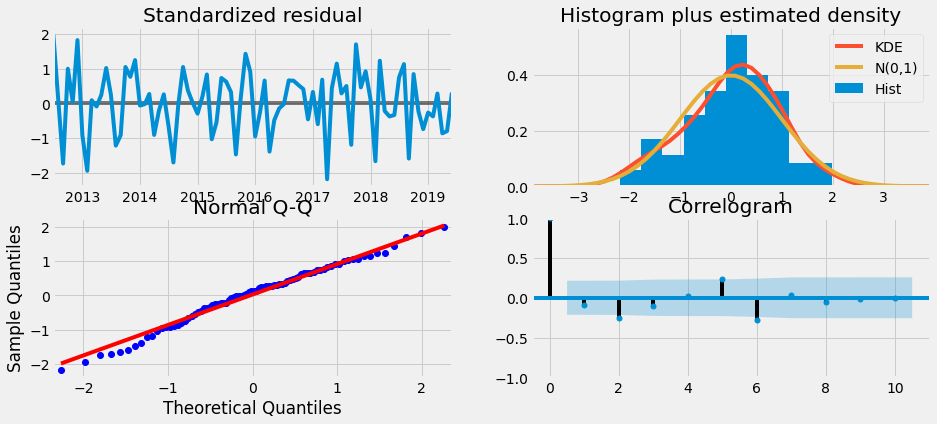

In [79]:
model1.plot_diagnostics(figsize=(14,6))
plt.show()

#### Normalité des résidus

#### Adhésion loi normale des résidus
H0 : distribution selon loi normale

In [80]:
shapiro(model1.resid)

(0.4347810745239258, 6.018525770521937e-17)

* SARIMA(3,0,3)x(2,0,1,12) meilleurs paramètres


### Forecast

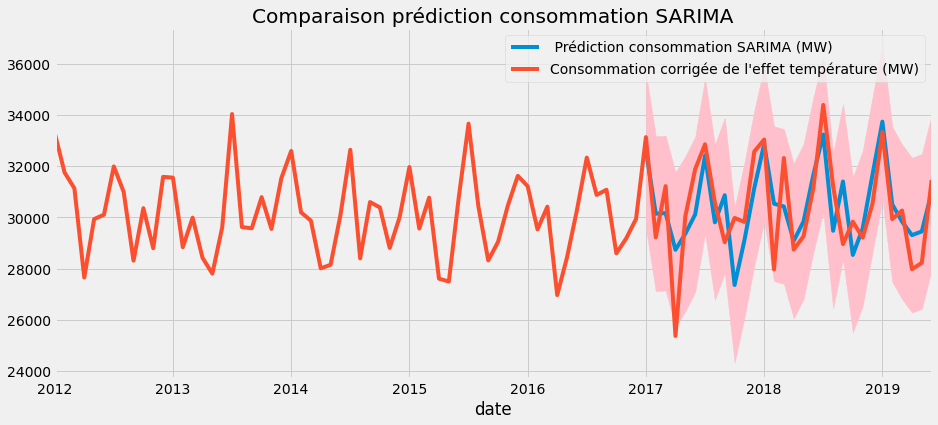

In [81]:
# prediction du 30
forecast = model1.get_prediction(start = -30)
# forecast mean
mean_forecast = forecast.predicted_mean
# confidence intervals
confidence_intervals = forecast.conf_int()
# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()

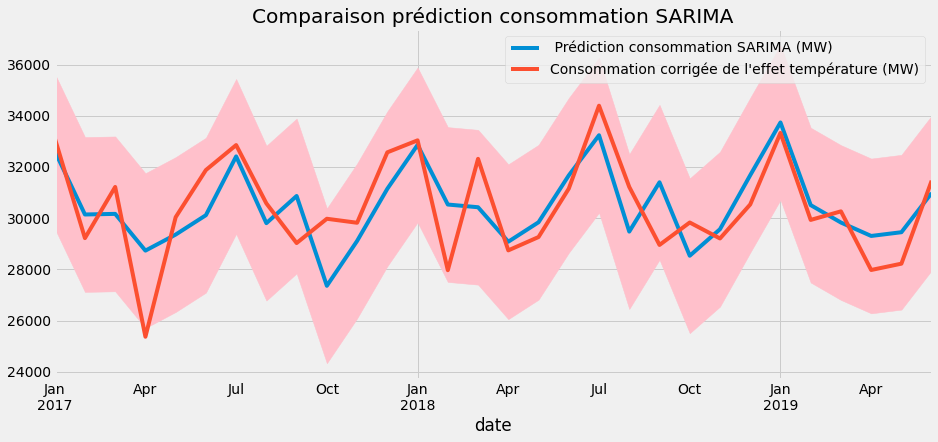

In [82]:
# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data_test["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()

### Evaluations prédictions

In [83]:
df = pd.DataFrame({'Actual': data_test["consommation_corrigee"], 'Predicted': mean_forecast })
df = df.dropna()

#### Comparaison actuel - predicted

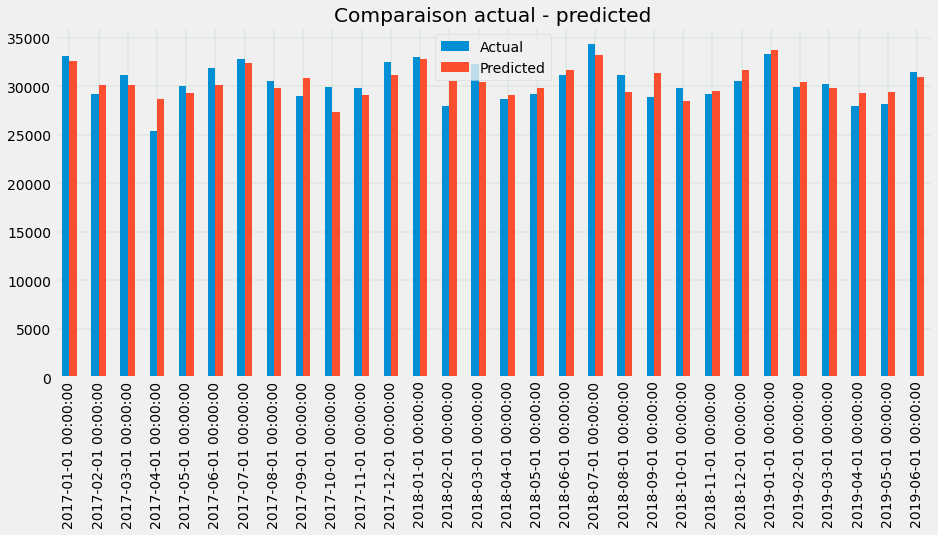

In [84]:
# comparaison graphique pred et actual
df1 = df
df1.plot(kind='bar',figsize=(14,6))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
plt.title("Comparaison actual - predicted")
plt.show()

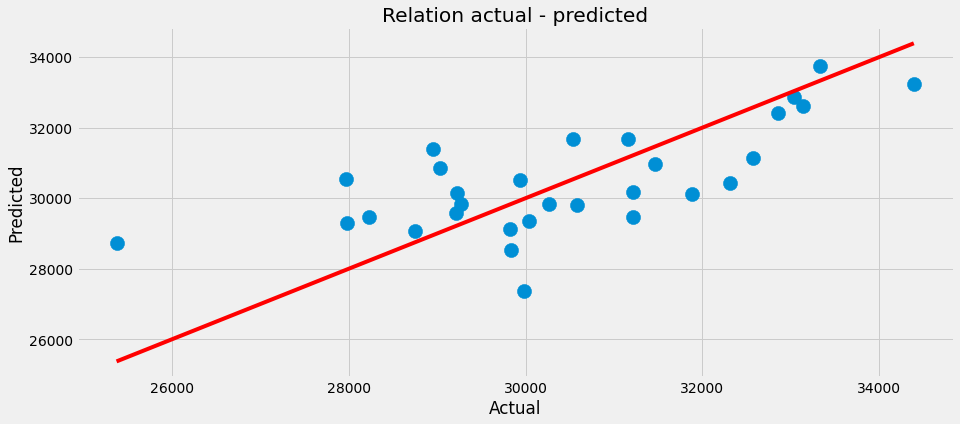

In [85]:
# comparaison graphique pred et actual
df1.plot(kind='scatter',x = "Actual", y = "Predicted",figsize=(14,6), s=200)
ident = [min(df1.Actual),max(df1.Actual)]
plt.plot(ident,ident, color = "r")
plt.title("Relation actual - predicted")
plt.show()

#### rmse et mape

In [86]:
rmse = np.sqrt(((df.Actual-df.Predicted)**2).mean())
rmse

1404.8799895215775

In [87]:
mape=(np.abs(1-df.Predicted/df.Actual)).mean()*100
round(mape,2)

3.9

### Recherche sur grille paramètres model SARIMA 12 mois

* Recherche avec saisonnalité de 12 sur 1 différences

In [88]:
# recherche sur grille
stepwise_model = auto_arima(data["consommation_corrigee"], m=12,
                           D=1,seasonal=True,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='aic')
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,12) [intercept=True]; AIC=1338.289, BIC=1357.142, Time=2.734 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1344.476, BIC=1349.189, Time=0.019 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=1344.631, BIC=1354.058, Time=0.251 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1343.809, BIC=1353.235, Time=0.277 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1342.479, BIC=1344.835, Time=0.021 seconds
Fit ARIMA(2,0,2)x(0,1,1,12) [intercept=True]; AIC=1339.170, BIC=1355.667, Time=2.565 seconds
Fit ARIMA(2,0,2)x(1,1,0,12) [intercept=True]; AIC=1339.221, BIC=1355.718, Time=1.321 seconds
Fit ARIMA(2,0,2)x(2,1,1,12) [intercept=True]; AIC=1341.618, BIC=1362.829, Time=4.158 seconds
Fit ARIMA(2,0,2)x(1,1,2,12) [intercept=True]; AIC=1341.629, BIC=1362.840, Time=4.651 seconds
Fit ARIMA(2,0,2)x(0,1,0,12) [intercept=True]; AIC=1338.812, BIC=1352.953, Time=0.291 seconds
Fit ARIMA(2,0,2)x(0,1,2,12

* SARIMA(4,0,2)x(0,1,0,12) meilleurs paramètres
* AIC = 1329


### Model 2

* SARIMA(4,0,2)x(0,1,0,12) meilleurs paramètres
* AIC = 1329


In [89]:
# Fit model
model = SARIMAX(data["consommation_corrigee"], order=(4,0,2),seasonal_order=(0,1,0,12))
model2 = model.fit()
print(model2.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:               consommation_corrigee   No. Observations:                   90
Model:             SARIMAX(4, 0, 2)x(0, 1, [], 12)   Log Likelihood                -656.728
Date:                             Fri, 17 Jul 2020   AIC                           1327.456
Time:                                     13:44:22   BIC                           1343.953
Sample:                                 01-01-2012   HQIC                          1334.060
                                      - 06-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1431      0.133     -8.595      0.000      -1.404      -0.882
ar.L2         -0.9255      

### Analyse résidus

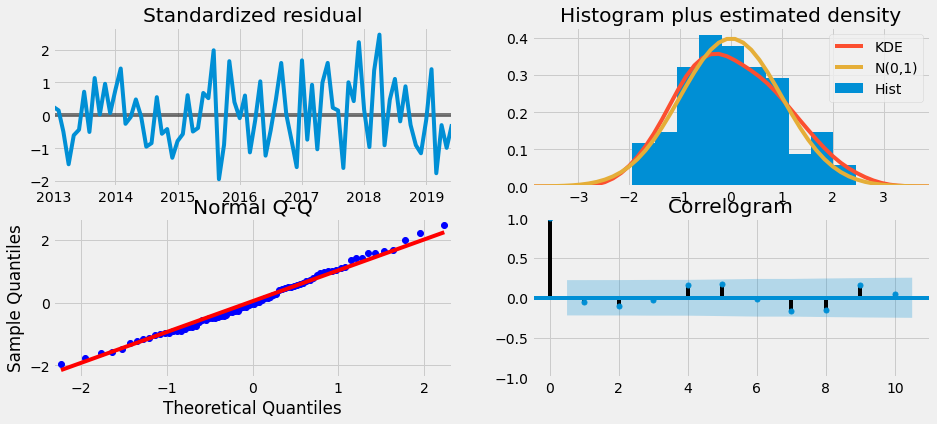

In [90]:
model2.plot_diagnostics(figsize=(14,6))
plt.show()

#### Normalité des résidus

#### Adhésion loi normale des résidus
H0 : distribution selon loi normale

In [91]:
shapiro(model2.resid)

(0.4960687756538391, 4.889315046546197e-16)

* SARIMA(3,0,3)x(2,0,1,12) meilleurs paramètres


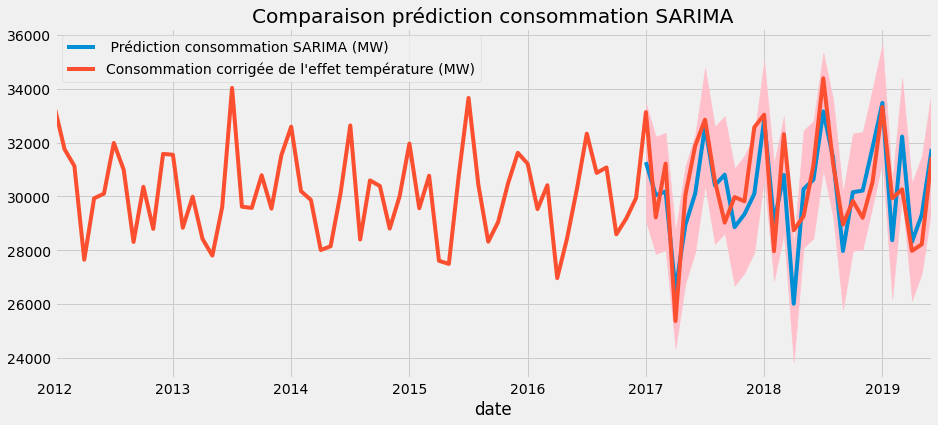

In [92]:
# prediction sur 30 
forecast = model2.get_prediction(start = -30)
# forecast mean
mean_forecast = forecast.predicted_mean
# confidence intervals
confidence_intervals = forecast.conf_int()
# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()

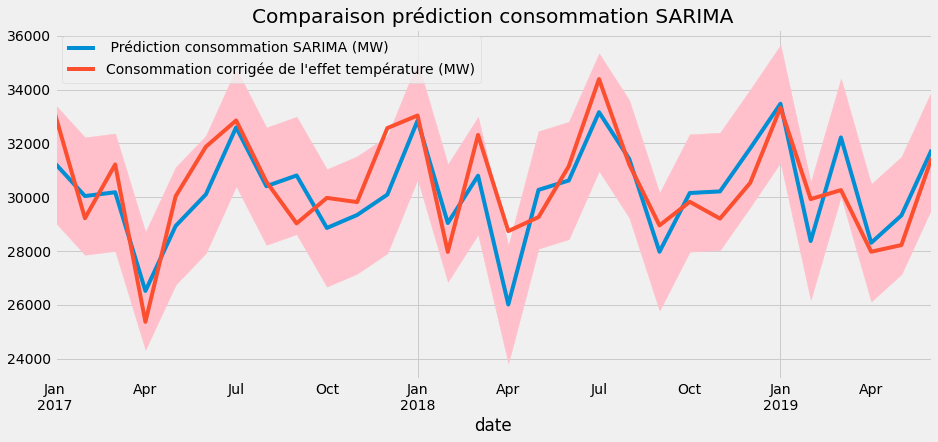

In [93]:
# comparaison graphique pred et actual
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data_test["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()

### Evaluations prédictions

In [94]:
df = pd.DataFrame({'Actual': data_test["consommation_corrigee"], 'Predicted': mean_forecast })
df = df.dropna()

#### Comparaison actuel - predicted

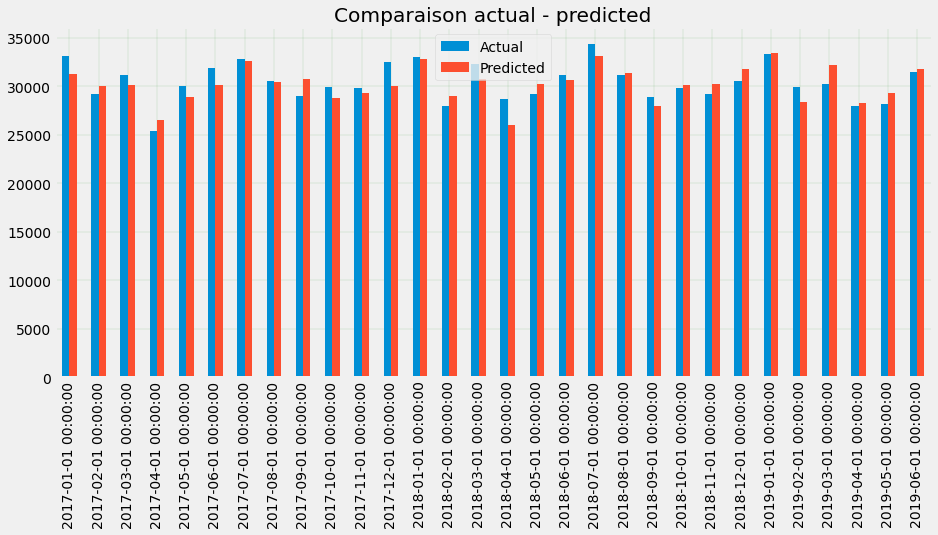

In [95]:
# comparaison graphique pred et actual
df1 = df
df1.plot(kind='bar',figsize=(14,6))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
plt.title("Comparaison actual - predicted")
plt.show()

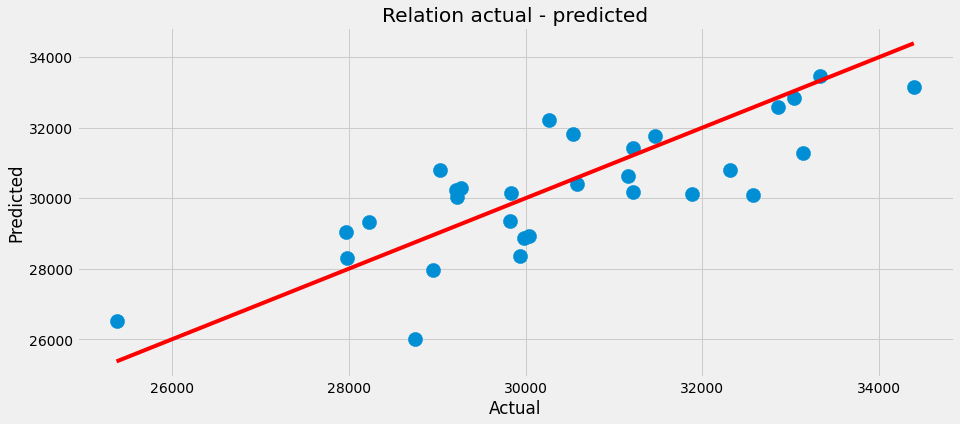

In [96]:
# comparaison graphique pred et actual
df1.plot(kind='scatter',x = "Actual", y = "Predicted",figsize=(14,6), s=200)
ident = [min(df1.Actual),max(df1.Actual)]
plt.plot(ident,ident, color = "r")
plt.title("Relation actual - predicted")
plt.show()

#### rmse et mape

In [97]:
rmse = np.sqrt(((df.Actual-df.Predicted)**2).mean())
rmse

1251.0725443181773

In [98]:
mape=(np.abs(1-df.Predicted/df.Actual)).mean()*100
round(mape,2)

3.47

# Prévision

SARIMA(4,0,2)x(0,1,0,12) meilleur modèle

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


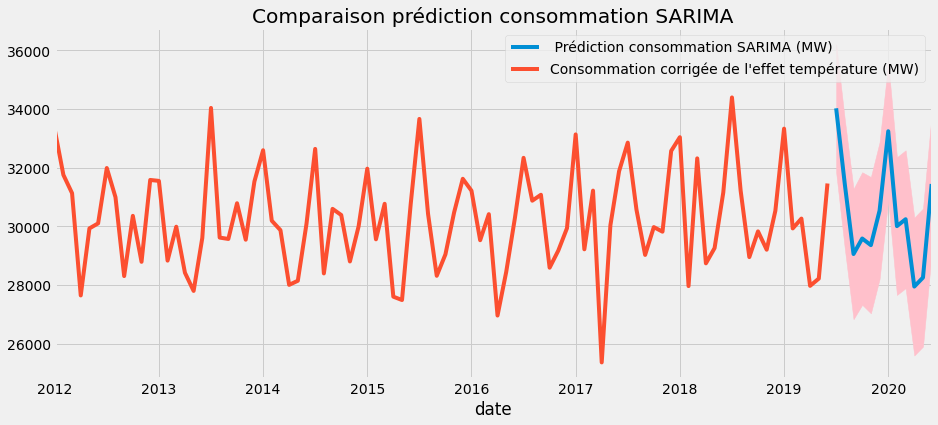

In [99]:
# préparation model
model = SARIMAX(data["consommation_corrigee"], order=(4,0,2),seasonal_order=(0,1,0,12))
# entrainement modele
model = model.fit()
# prévision
forecast = model.get_forecast(steps = 12)
# forecast mean
mean_forecast = forecast.predicted_mean
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
# graphique prédictions
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()

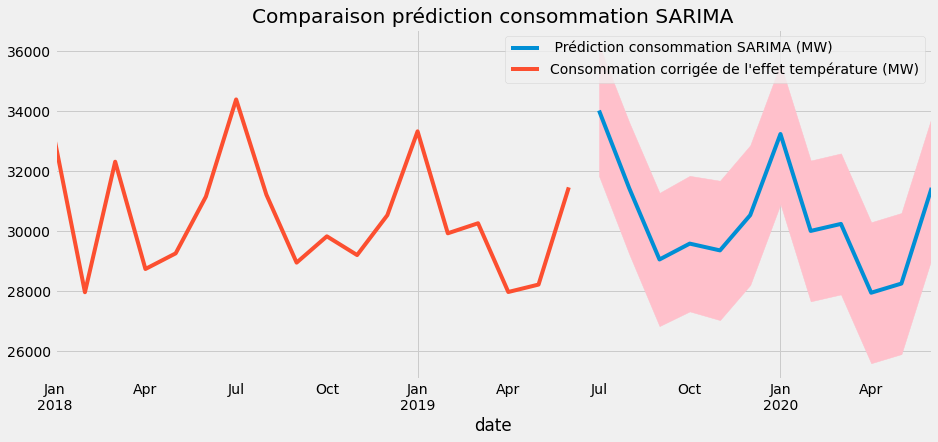

In [100]:
# graphique prédictions
fig, ax = plt.subplots(1,1, figsize=(14,6))
mean_forecast.plot(ax = ax, label=" Prédiction consommation SARIMA (MW)")
data_test.loc["2018":]["consommation_corrigee"].plot(ax=ax,label="Consommation corrigée de l'effet température (MW)")
plt.legend()
plt.title("Comparaison prédiction consommation SARIMA")
plt.fill_between(confidence_intervals.index,confidence_intervals["lower consommation_corrigee"],
                 confidence_intervals["upper consommation_corrigee"],color='pink')
plt.show()